In [1]:
# import cplex
# import networkx as nx
# import time
# import csv

# epsilon = 0.01

# def adapt_instance_data(V, A, d, C, K, Viz):
#     """
#     Adapta a estrutura de dados do instance_reader para o formato esperado
#     pela função solve_CROMD_cplex.

#     Args:
#         V: [0, 1, 2, ..., n-1] do instance_reader (inclui depot)
#         A: [(i,j), ...] do instance_reader
#         d: {(i,j): distance} do instance_reader (dicionário flat)
#         C: capacidade dos drones
#         K: número de drones
#         Viz: lista 0-indexed com vizinhanças

#     Returns:
#         (V_adapted, d_adapted, Viz_adapted) no formato esperado
#     """
#     # Remove depot (0) de V para criar lista 1-indexed
#     V_adapted = [i for i in V if i != 0]

#     # Converte dicionário flat {(i,j): val} para nested {i: {j: val}}
#     d_adapted = {}
#     for (i, j) in A:
#         if i not in d_adapted:
#             d_adapted[i] = {}
#         d_adapted[i][j] = d[(i, j)]

#     # Adapta Viz: mantém dados mas ajusta para acesso com V 1-indexed
#     # viz_cobertura[i-1] para sensor i corresponde a Viz[i]
#     Viz_adapted = []
#     for i in V_adapted:
#         Viz_adapted.append(Viz[i])

#     return V_adapted, d_adapted, Viz_adapted

# def build_CROMD_cplex(V, A, d, C, K, viz_cobertura):
#     V_full = [0] + V
#     cpx = cplex.Cplex()
#     cpx.objective.set_sense(cpx.objective.sense.minimize)
#     x_id = {}
#     y_id = {}

#     for k in range(K):
#         for (i, j) in A:
#             name = f"x_{k}_{i}_{j}"
#             idx = cpx.variables.add(
#                 obj=[0.0],
#                 lb=[0.0],
#                 ub=[1.0],
#                 types=["B"],
#                 names=[name]
#             )[0]
#             x_id[(k, i, j)] = idx

#     for k in range(K):
#         for i in V_full:
#             name = f"y_{k}_{i}"
#             idx = cpx.variables.add(
#                 obj=[0.0],
#                 lb=[0.0],
#                 ub=[1.0],
#                 types=["B"],
#                 names=[name]
#             )[0]
#             y_id[(k, i)] = idx

#     T_id = cpx.variables.add(
#         obj=[1.0],
#         lb=[0.0],
#         ub=[cplex.infinity],
#         types=["C"],
#         names=["T"]
#     )[0]

#     # Cobertura
#     for i in V:
#         ind, val = [], []
#         for k in range(K):
#             for j in viz_cobertura[i - 1] + [i]:
#                 ind.append(y_id[(k, j)])
#                 val.append(1.0)
#         cpx.linear_constraints.add(
#             lin_expr=[cplex.SparsePair(ind, val)],
#             senses=["G"],
#             rhs=[1.0]
#         )

#     for k in range(K):
#         for i in V_full:
#             out_ind, out_val = [], []
#             in_ind, in_val = [], []

#             for j in V_full:
#                 if i != j:
#                     if (k, i, j) in x_id:
#                         out_ind.append(x_id[(k, i, j)])
#                         out_val.append(1.0)
#                     if (k, j, i) in x_id:
#                         in_ind.append(x_id[(k, j, i)])
#                         in_val.append(1.0)

#             out_ind.append(y_id[(k, i)])
#             out_val.append(-1.0)
#             in_ind.append(y_id[(k, i)])
#             in_val.append(-1.0)
#             cpx.linear_constraints.add(
#                 lin_expr=[cplex.SparsePair(out_ind, out_val)],
#                 senses=["E"],
#                 rhs=[0.0]
#             )
#             cpx.linear_constraints.add(
#                 lin_expr=[cplex.SparsePair(in_ind, in_val)],
#                 senses=["E"],
#                 rhs=[0.0]
#             )

#     # NOVA CONSTRAINT: Forçar conexão à base
#     # Para cada drone k: se ele é usado (visita algum sensor), deve partir e retornar à base
#     for k in range(K):
#         # Constraint 1: No máximo uma saída da base
#         out_base_ind, out_base_val = [], []
#         for j in V:  # Arcos da base (0) para sensores
#             if (k, 0, j) in x_id:
#                 out_base_ind.append(x_id[(k, 0, j)])
#                 out_base_val.append(1.0)
#         if out_base_ind:
#             cpx.linear_constraints.add(
#                 lin_expr=[cplex.SparsePair(out_base_ind, out_base_val)],
#                 senses=["L"],
#                 rhs=[1.0],
#                 names=[f"max_one_departure_k{k}"]
#             )
        
#         # # Constraint 2: No máximo um retorno à base
#         # in_base_ind, in_base_val = [], []
#         # for j in V:  # Arcos de sensores para a base (0)
#         #     if (k, j, 0) in x_id:
#         #         in_base_ind.append(x_id[(k, j, 0)])
#         #         in_base_val.append(1.0)
#         # if in_base_ind:
#         #     cpx.linear_constraints.add(
#         #         lin_expr=[cplex.SparsePair(in_base_ind, in_base_val)],
#         #         senses=["L"],
#         #         rhs=[1.0],
#         #         names=[f"max_one_return_k{k}"]
#         #     )
        
#         # Constraint 3: Número de saídas da base = número de entradas na base
#         # Isso garante que se sai, deve voltar
#         if out_base_ind and in_base_ind:
#             balance_ind = out_base_ind + in_base_ind
#             balance_val = [1.0] * len(out_base_ind) + [-1.0] * len(in_base_ind)
#             cpx.linear_constraints.add(
#                 lin_expr=[cplex.SparsePair(balance_ind, balance_val)],
#                 senses=["E"],
#                 rhs=[0.0],
#                 names=[f"depot_balance_k{k}"]
#             )
        
#         # Constraint 4: Se visita algum sensor (y_k_i = 1 para i != 0), deve sair da base
#         # sum(y_k_i para i em V) <= |V| * sum(x_k_0_j para j em V)
#         # Isso garante que se visita sensores, deve partir da base
#         if out_base_ind:
#             visit_ind = []
#             visit_val = []
#             for i in V:
#                 visit_ind.append(y_id[(k, i)])
#                 visit_val.append(1.0)
#             for j in range(len(out_base_ind)):
#                 visit_ind.append(out_base_ind[j])
#                 visit_val.append(-len(V))
#             cpx.linear_constraints.add(
#                 lin_expr=[cplex.SparsePair(visit_ind, visit_val)],
#                 senses=["L"],
#                 rhs=[0.0],
#                 names=[f"force_depot_departure_k{k}"]
#             )

#     # Autonomia C
#     for k in range(K):
#         ind, val = [], []
#         for (i, j) in A:
#             ind.append(x_id[(k, i, j)])
#             val.append(d[i][j])
#         cpx.linear_constraints.add(
#             lin_expr=[cplex.SparsePair(ind, val)],
#             senses=["L"],
#             rhs=[C]
#         )

#     # Makespan T
#     for k in range(K):
#         ind, val = [], []
#         for (i, j) in A:
#             ind.append(x_id[(k, i, j)])
#             val.append(d[i][j])
#         ind.append(T_id)
#         val.append(-1.0)
#         cpx.linear_constraints.add(
#             lin_expr=[cplex.SparsePair(ind, val)],
#             senses=["L"],
#             rhs=[0.0]
#         )

#     # Simetria das distacnias
#     for k in range(K - 1):
#         ind, val = [], []
#         for (i, j) in A:
#             ind.append(x_id[(k, i, j)])
#             val.append(d[i][j])
#             ind.append(x_id[(k + 1, i, j)])
#             val.append(-d[i][j])
#         cpx.linear_constraints.add(
#             lin_expr=[cplex.SparsePair(ind, val)],
#             senses=["G"],
#             rhs=[0.0]
#         )

#     return cpx, x_id, y_id, T_id

# class CROMDCallback:
#     """
#     Callback para separação de cut-set constraints com DEBUG ULTRA DETALHADO.

#     Seguindo o padrão de examples/admipex8.py:
#     - User cuts: min-cut no grafo auxiliar (soluções fracionárias)
#     - Lazy constraints: componentes conexas (soluções inteiras) [OBRIGATÓRIO]
#     """

#     def __init__(self, V_input, K, x_id, y_id):
#         """
#         Args:
#             V_input: Lista [0, 1, 2, ..., n-1] (V' na notação matemática)
#             K: Número de drones
#             x_id: Dicionário (k, i, j) -> índice da variável x^k_{ij}
#             y_id: Dicionário (k, i) -> índice da variável y^k_i
#         """
#         self.V_prime = V_input
#         self.K = K
#         self.x_id = x_id
#         self.y_id = y_id
#         self.user_cut_count = 0
#         self.lazy_cut_count = 0
#         self.callback_call_count = 0

#     def analyze_symmetric_arcs(self, active_arcs_by_drone):
#         """Detecta arcos simétricos (i,j) e (j,i) no mesmo drone."""
#         symmetric_arcs = []

#         for k in range(self.K):
#             arcs = active_arcs_by_drone.get(k, [])
#             for i, j, val_ij in arcs:
                # Procurar arco reverso (j,i) no mesmo drone
#                 for i2, j2, val_ji in arcs:
#                     if i2 == j and j2 == i:
#                         symmetric_arcs.append((k, i, j, val_ij, val_ji))
#                         break

#         return symmetric_arcs

#     def build_cut(self, S):
#         """Monta a desigualdade de cut-set para um conjunto S (sem base)."""
#         indices = []
#         coefficients = []
#         cut_edges = []

#         for k in range(self.K):
#             for i in S:
#                 for j in self.V_prime:
#                     if j in S:
#                         continue
#                     if (k, i, j) in self.x_id:
#                         indices.append(self.x_id[(k, i, j)])
#                         coefficients.append(1.0)
#                         cut_edges.append(f"x[{k},{i},{j}]")
#                     if (k, j, i) in self.x_id:
#                         indices.append(self.x_id[(k, j, i)])
#                         coefficients.append(1.0)
#                         cut_edges.append(f"x[{k},{j},{i}]")

#         return indices, coefficients, cut_edges

#     def collect_subtour_arcs(self, active_arcs_by_drone, S):
#         """Lista arcos ativos internos a S para debug."""
#         arcs = []
#         S_set = set(S)

#         for k, arcs_list in active_arcs_by_drone.items():
#             for i, j, val in arcs_list:
#                 if i in S_set and j in S_set:
#                     arcs.append((k, i, j, val))

#         return arcs

#     def print_solution_details(self, context, is_integer):
#         """Imprime detalhes completos da solução atual."""
#         get_value = context.get_candidate_point if is_integer else context.get_relaxation_point
#         sol_type = "INTEIRA" if is_integer else "FRACIONÁRIA"

#         print(f"
# {'='*100}")
#         print(f"ANÁLISE DETALHADA DA SOLUÇÃO {sol_type}")
#         print(f"{'='*100}")

        # 1. Valores de y (visitação)
#         print(f"
# [1] VALORES DE VISITAÇÃO y^k_i:")
#         y_values = {}
#         for k in range(self.K):
#             drone_visits = []
#             for i in self.V_prime:
#                 val = get_value(self.y_id[(k, i)])
#                 y_values[(k, i)] = val
#                 if val > EPS:
#                     drone_visits.append((i, val))
#             if drone_visits:
#                 print(f"  Drone {k}: {', '.join([f'y[{i}]={v:.4f}' for i, v in drone_visits])}")

        # 2. Verificar se base está sendo visitada
#         base_visited = False
#         base_values = []
#         for k in range(self.K):
#             val = y_values.get((k, 0), 0.0)
#             if val > EPS:
#                 base_visited = True
#                 base_values.append((k, val))

#         if base_visited:
#             print(f"
# [2] BASE (nó 0) ESTÁ SENDO VISITADA:")
#             for k, val in base_values:
#                 print(f"  y[0] no drone {k} = {val:.4f}")
#         else:
#             print(f"
# [2] *** ALERTA: BASE (nó 0) NÃO ESTÁ SENDO VISITADA ***")
#             print(f"  Valores y[0] por drone:")
#             for k in range(self.K):
#                 val = y_values.get((k, 0), 0.0)
#                 print(f"    Drone {k}: y[0] = {val:.6f} {'<= epsilon' if val <= EPS else '> epsilon'}")

        # 3. Arcos ativos por drone
#         print(f"
# [3] ARCOS ATIVOS x^k_{{ij}} > epsilon:")
#         active_arcs_by_drone = {}

#         for k in range(self.K):
#             arcs = []
#             for (k_var, i, j), var_id in self.x_id.items():
#                 if k_var == k:
#                     val = get_value(var_id)
#                     if val > EPS:
#                         arcs.append((i, j, val))

#             active_arcs_by_drone[k] = arcs

#             if arcs:
#                 print(f"  Drone {k}: {len(arcs)} arcos ativos")
#                 for i, j, val in sorted(arcs):
#                     print(f"    x[{k},{i},{j}] = {val:.4f}")

        # 4. Detectar arcos simétricos
#         symmetric_arcs = self.analyze_symmetric_arcs(active_arcs_by_drone)
#         if symmetric_arcs:
#             print(f"
# [4] *** ARCOS SIMÉTRICOS DETECTADOS (ciclos de 2 nós) ***")
#             for k, i, j, val_ij, val_ji in symmetric_arcs:
#                 print(f"  Drone {k}: x[{k},{i},{j}]={val_ij:.4f} e x[{k},{j},{i}]={val_ji:.4f}")
#         else:
#             print(f"
# [4] Nenhum arco simétrico detectado")

#         return y_values, active_arcs_by_drone, base_visited

#     def separate_user_cuts(self, context):
#         """USER CUTS: Separação para soluções fracionárias usando min-cut."""
#         self.callback_call_count += 1

#         print(f"
# {'#'*100}")
#         print(f"CALLBACK #{self.callback_call_count}: USER CUT (Solução FRACIONÁRIA)")
#         print(f"{'#'*100}")

        # Análise detalhada da solução
#         y_values, active_arcs_by_drone, base_visited = self.print_solution_details(context, is_integer=False)

        # W(x,y) := {i ∈ V' : ∑_{k=1}^{K} y^k_i > 0}
#         W = []
#         aggregated_y = {}
#         for i in self.V_prime:
#             sum_y_i = sum(y_values.get((k, i), 0.0) for k in range(self.K))
#             aggregated_y[i] = sum_y_i
#             if sum_y_i > EPS:
#                 W.append(i)

#         print(f"
# [5] NÓS ATIVOS W (∑_k y^k_i > ε):")
#         print(f"  W = {sorted(W)} (|W| = {len(W)})")
#         for i in sorted(aggregated_y.keys()):
#             if aggregated_y[i] > EPS:
#                 print(f"  ∑_k y^k_{i} = {aggregated_y[i]:.4f}")

#         cuts_added = 0
#         violations_found = 0
#         base_forced_cuts = 0
#         seen_cuts = set()

        # VERIFICAÇÃO CRÍTICA: Base está ativa?
#         if 0 not in W:
#             print(f"
# {'*'*100}")
#             print(f"*** MOTIVO DE CORTE FORÇADO: Base (0) NÃO está em W ***")
#             print(f"*** ∑_k y^k_0 = {aggregated_y.get(0, 0.0):.6f} <= epsilon ({EPS}) ***")
#             print(f"*** SOLUÇÃO FRACIONÁRIA SEM BASE - DEVERIA SER INVIÁVEL ***")
#             print(f"*** Isso indica problema nas restrições do modelo base ***")
#             print(f"{'*'*100}")

#             if W:
#                 subtour_arcs = self.collect_subtour_arcs(active_arcs_by_drone, W)
#                 print(f"
# Arcos do subtour:")
#                 if subtour_arcs:
#                     for k, i, j, val in subtour_arcs:
#                         print(f"  x[{k},{i},{j}] = {val:.4f}")
#                 else:
#                     print("  (nenhum arco interno ativo)")

#                 indices, coefficients, cut_edges = self.build_cut(W)
#                 print(f"User cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
#                 if len(cut_edges) <= 20:
#                     print(f"Variáveis: {', '.join(cut_edges)}")

#                 cutmanagement = cplex.callbacks.UserCutCallback.use_cut.purge
#                 context.add_user_cut(
#                     cut=cplex.SparsePair(indices, coefficients),
#                     sense="G",
#                     rhs=2.0,
#                     cutmanagement=cutmanagement,
#                     local=False
#                 )
#                 cuts_added += 1
#                 base_forced_cuts += 1
#                 self.user_cut_count += 1
#                 seen_cuts.add(frozenset(W))

#                 print("
# >>> REJEITANDO SOLUÇÃO CANDIDATA <<<")
#                 print("1 user cut adicionada")
#             else:
#                 print("
# W vazio: não foi possível gerar corte para a ausência da base.")

        # Construir grafo auxiliar G* com capacidades c_{ij} = x̄*_{ij}
#         nodes_for_graph = sorted(set(W) | {0})
#         G_star = nx.Graph()
#         G_star.add_nodes_from(nodes_for_graph)

#         print(f"
# [6] CONSTRUINDO GRAFO AUXILIAR G*:")
#         edge_capacities = {}
#         for i in nodes_for_graph:
#             for j in nodes_for_graph:
#                 if i < j:
                    # c_{ij} = ∑_{k=1}^{K} (x^k_{ij} + x^k_{ji})
#                     capacity = 0.0
#                     for k in range(self.K):
#                         if (k, i, j) in self.x_id:
#                             capacity += context.get_relaxation_point(self.x_id[(k, i, j)])
#                         if (k, j, i) in self.x_id:
#                             capacity += context.get_relaxation_point(self.x_id[(k, j, i)])

#                     if capacity > EPS:
#                         G_star.add_edge(i, j, capacity=capacity)
#                         edge_capacities[(i, j)] = capacity

#         print(f"  Grafo G* com {len(G_star.edges)} arestas (capacidade > ε)")

        # Para cada r ∈ W \ {0}, computar corte mínimo
#         print(f"
# [7] SEPARAÇÃO DE MIN-CUTS:")

#         for r in W:
#             if r == 0:
#                 continue

#             try:
#                 cut_value, (S, T) = nx.minimum_cut(G_star, 0, r, capacity="capacity")
#             except nx.NetworkXError:
#                 print(f"  Nó {r}: DESCONEXO do nó 0 (sem caminho)")
#                 continue

            # Garantir 0 ∉ S_r
#             if 0 in S:
#                 S_r = T
#             else:
#                 S_r = S

#             if not S_r or 0 in S_r:
#                 continue

#             if frozenset(S_r) in seen_cuts:
#                 continue

            # Verificar violação: C(S_r) < 2
#             if cut_value < 2.0 - EPS:
#                 violations_found += 1
#                 print(f"
#   >>> VIOLAÇÃO #{violations_found} DETECTADA (nó r={r}) <<<")
#                 print(f"    Valor do corte: {cut_value:.4f} < 2.0")
#                 print(f"    Conjunto S_r (sem base): {sorted(S_r)}")
#                 print(f"    Complemento (com base): {sorted([n for n in nodes_for_graph if n not in S_r])}")

                # Construir user cut
#                 indices, coefficients, cut_edges = self.build_cut(S_r)

#                 print(f"    User cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
#                 if len(cut_edges) <= 20:
#                     print(f"    Variáveis: {', '.join(cut_edges)}")

                # Adicionar user cut
#                 cutmanagement = cplex.callbacks.UserCutCallback.use_cut.purge
#                 context.add_user_cut(
#                     cut=cplex.SparsePair(indices, coefficients),
#                     sense="G",
#                     rhs=2.0,
#                     cutmanagement=cutmanagement,
#                     local=False
#                 )
#                 cuts_added += 1
#                 self.user_cut_count += 1
#                 seen_cuts.add(frozenset(S_r))

#         print(f"
# [8] RESUMO:")
#         print(f"  Violações detectadas: {violations_found}")
#         print(f"  User cuts adicionados: {cuts_added} (base forçada: {base_forced_cuts})")
#         print(f"  Total acumulado: {self.user_cut_count} user cuts")
#         print(f"{'#'*100}
# ")

#     def separate_lazy_constraints(self, context):
#         """LAZY CONSTRAINTS: Separação obrigatória para soluções inteiras."""
#         self.callback_call_count += 1

#         print(f"
# {'#'*100}")
#         print(f"CALLBACK #{self.callback_call_count}: LAZY CUT (Solução INTEIRA)")
#         print(f"{'#'*100}")

        # Verificação de bounded solution
#         if not context.is_candidate_point():
#             raise Exception('Unbounded solution')

        # Análise detalhada da solução
#         y_values, active_arcs_by_drone, base_visited = self.print_solution_details(context, is_integer=True)

        # W(x,y) := {i ∈ V' : ∑_{k=1}^{K} y^k_i > 0}
#         W = []
#         aggregated_y = {}
#         for i in self.V_prime:
#             sum_y_i = sum(y_values.get((k, i), 0.0) for k in range(self.K))
#             aggregated_y[i] = sum_y_i
#             if sum_y_i > EPS:
#                 W.append(i)

#         print(f"
# [5] NÓS ATIVOS W (∑_k y^k_i > ε):")
#         print(f"  W = {sorted(W)} (|W| = {len(W)})")

#         base_missing = 0 not in W

#         if base_missing:
#             print(f"
# {'*'*100}")
#             print(f"*** MOTIVO DE CORTE FORÇADO: Base (0) NÃO está em W ***")
#             print(f"*** ∑_k y^k_0 = {aggregated_y.get(0, 0.0):.6f} <= epsilon ({EPS}) ***")
#             print(f"*** SOLUÇÃO INTEIRA SEM BASE - DEVERIA SER INVIÁVEL ***")
#             print(f"*** Isso indica problema nas restrições do modelo base ***")
#             print(f"*** VERIFICANDO SE RESTRIÇÃO ESTÁ SENDO VIOLADA... ***")

#             for k in range(self.K):
#                 sum_sensors = sum(y_values.get((k, j), 0.0) for j in [i for i in self.V_prime if i != 0])
#                 y_depot = y_values.get((k, 0), 0.0)

#                 if sum_sensors > EPS and y_depot <= EPS:
#                     print(f"  Drone {k}: ∑ y^k_j (sensores) = {sum_sensors:.4f}, y^k_0 = {y_depot:.6f}")
#                     print(f"    VIOLAÇÃO: drone visita sensores mas não visita base!")

#             print(f"{'*'*100}
# ")

        # Construir grafo com arestas onde x̄_{ij} = 1 (inteiro)
#         print(f"
# [6] CONSTRUINDO GRAFO DE ARCOS INTEIROS (x̄_{{ij}} ≈ 1):")
#         nodes_for_graph = sorted(set(W) | {0})
#         G_integer = nx.Graph()
#         G_integer.add_nodes_from(nodes_for_graph)

#         active_edges = []
#         for i in nodes_for_graph:
#             for j in nodes_for_graph:
#                 if i < j:
                    # x̄_{ij} = ∑_{k=1}^{K} (x^k_{ij} + x^k_{ji})
#                     x_bar = 0.0
#                     edge_details = []
#                     for k in range(self.K):
#                         val_ij = 0.0
#                         val_ji = 0.0
#                         if (k, i, j) in self.x_id:
#                             val_ij = context.get_candidate_point(self.x_id[(k, i, j)])
#                         if (k, j, i) in self.x_id:
#                             val_ji = context.get_candidate_point(self.x_id[(k, j, i)])

#                         if val_ij > EPS or val_ji > EPS:
#                             edge_details.append((k, val_ij, val_ji))
#                         x_bar += val_ij + val_ji

#                     if x_bar > 1.0 - EPS:
#                         G_integer.add_edge(i, j)
#                         active_edges.append((i, j, x_bar, edge_details))

#         print(f"  Grafo com {len(G_integer.edges)} arestas (x̄_{{ij}} ≈ 1)")
#         if active_edges:
#             for i, j, x_bar, details in active_edges[:15]:
#                 print(f"    Arco ({i},{j}): x̄={x_bar:.4f}")
#                 for k, val_ij, val_ji in details:
#                     if val_ij > EPS:
#                         print(f"      x[{k},{i},{j}]={val_ij:.4f}")
#                     if val_ji > EPS:
#                         print(f"      x[{k},{j},{i}]={val_ji:.4f}")

        # Detectar componentes conexas
#         components = list(nx.connected_components(G_integer))
#         print(f"
# [7] COMPONENTES CONEXAS DETECTADAS: {len(components)}")

#         for idx, comp in enumerate(components):
#             contains_base = 0 in comp
#             status = "VÁLIDA (contém base)" if contains_base else "*** SUBTOUR (sem base) ***"
#             print(f"  Componente #{idx+1}: {sorted(comp)} - {status}")

#             comp_edges = [(i, j) for i, j in G_integer.edges() if i in comp and j in comp]
#             if comp_edges and not contains_base:
#                 print(f"    Arcos internos: {comp_edges}")

#         violated_components = [
#             S for S in components
#             if 0 not in S and any(node in W for node in S)
#         ]

#         constraints = []

#         if violated_components:
#             print(f"
# {'*'*100}")
#             print(f"*** VIOLAÇÕES DETECTADAS: {len(violated_components)} SUBTOUR(S) DESCONEXO(S) ***")
#             print(f"{'*'*100}")

#             for idx, S in enumerate(violated_components):
#                 print(f"
#   SUBTOUR #{idx+1}:")
#                 print(f"    Nós: {sorted(S)} (|S| = {len(S)})")

#                 drones_in_subtour = set()
#                 for i in S:
#                     for k in range(self.K):
#                         if y_values.get((k, i), 0.0) > EPS:
#                             drones_in_subtour.add(k)

#                 print(f"    Drones envolvidos: {sorted(drones_in_subtour)}")

#                 subtour_arcs = self.collect_subtour_arcs(active_arcs_by_drone, S)
#                 print(f"    Arcos do subtour:")
#                 for k, i, j, val in subtour_arcs:
#                     print(f"      x[{k},{i},{j}] = {val:.4f}")

#                 indices, coefficients, cut_edges = self.build_cut(S)

#                 print(f"    Lazy cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
#                 if len(cut_edges) <= 20:
#                     print(f"    Variáveis: {', '.join(cut_edges[:20])}")

#                 constraints.append(cplex.SparsePair(indices, coefficients))
#                 self.lazy_cut_count += 1

#             print(f"
#   >>> REJEITANDO SOLUÇÃO CANDIDATA <<<")
#             print(f"  {len(constraints)} lazy constraints adicionadas")
#             context.reject_candidate(
#                 constraints=constraints,
#                 senses=["G"] * len(constraints),
#                 rhs=[2.0] * len(constraints)
#             )
#         else:
#             if base_missing:
#                 print(f"
# {'*'*100}")
#                 print(f"*** ALERTA: Base ausente, mas nenhum subtour foi gerado ***")
#                 print(f"*** Verifique a consistência das variáveis x/y ***")
#                 print(f"{'*'*100}")
#             else:
#                 print(f"
# {'*'*100}")
#                 print(f"*** SOLUÇÃO VÁLIDA: Todas as componentes estão conectadas à base ***")
#                 print(f"{'*'*100}")

#         print(f"
# [8] RESUMO:")
#         print(f"  Componentes totais: {len(components)}")
#         print(f"  Subtours detectados: {len(violated_components)}")
#         print(f"  Lazy cuts adicionados: {len(constraints)}")
#         print(f"  Total acumulado: {self.lazy_cut_count} lazy cuts")
#         print(f"{'#'*100}
# ")

#     def invoke(self, context):
#         """Método invoke seguindo EXATAMENTE o padrão de admipex8.py."""
#         try:
#             if context.in_relaxation():
#                 self.separate_user_cuts(context)
#             elif context.in_candidate():
#                 self.separate_lazy_constraints(context)
#         except:
#             info = sys.exc_info()
#             print('#### Exception in callback: ', info[0])
#             print('####                        ', info[1])
#             print('####                        ', info[2])
#             traceback.print_tb(info[2], file=sys.stdout)
#             raise


# def solve_CROMD_cplex(V, A, d, C, K, viz_cobertura, timelimit=60):
#     # Adapta dados do instance_reader para formato esperado
#     V_adapted, d_adapted, Viz_adapted = adapt_instance_data(V, A, d, C, K, viz_cobertura)
    
#     cpx, x_id, y_id, T_id = build_CROMD_cplex(V_adapted, A, d_adapted, C, K, Viz_adapted)
#     cpx.parameters.timelimit.set(timelimit)
#     cpx.parameters.threads.set(1)
#     cpx.parameters.preprocessing.presolve.set(0)
#     # cpx.parameters.mip.cuts.mircut.set(-1)
#     # cpx.parameters.mip.cuts.implied.set(-1)
#     # cpx.parameters.mip.cuts.gomory.set(-1)
#     # cpx.parameters.mip.cuts.flowcovers.set(-1)
#     # cpx.parameters.mip.cuts.pathcut.set(-1)
#     # cpx.parameters.mip.cuts.liftproj.set(-1)
#     # cpx.parameters.mip.cuts.zerohalfcut.set(-1)
#     # cpx.parameters.mip.cuts.cliques.set(-1)
#     # cpx.parameters.mip.cuts.covers.set(-1)

#     cb = CROMDCallback(V_adapted, K, x_id, y_id)
#     contextmask = (
#         cplex.callbacks.Context.id.relaxation |
#         cplex.callbacks.Context.id.candidate
#     )
#     cpx.set_callback(cb, contextmask)

#     start = time.time()
#     cpx.solve()
#     elapsed = time.time() - start

#     print("\nStatus:", cpx.solution.get_status())
#     print("Makespan:", cpx.solution.get_objective_value())
#     print("Tempo:", elapsed)

#     return cpx, x_id, y_id, T_id, elapsed


In [2]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as mcolors

# def extract_routes(cpx, x_id, K):
#     """
#     Extrai as rotas de cada drone da solução do CPLEX.
    
#     Args:
#         cpx: Objeto CPLEX com solução
#         x_id: Dicionário com IDs das variáveis x_{k,i,j}
#         K: Número de drones
    
#     Returns:
#         Lista de rotas, onde cada rota é uma lista de tuplas (i, j)
#     """
#     routes = []
#     solution_values = cpx.solution.get_values()
    
#     print(f"\n=== Debug: Extraindo rotas ===")
#     print(f"Número total de variáveis x: {len(x_id)}")
#     print(f"Número de drones (K): {K}")
    
#     # Verificar se há arcos envolvendo a base (sensor 0)
#     arcos_com_base = [(k, i, j) for (k, i, j) in x_id.keys() if i == 0 or j == 0]
#     print(f"Arcos envolvendo a base (sensor 0): {len(arcos_com_base)} de {len(x_id)}")
    
#     # Verificar se ALGUM arco com base está ativo
#     arcos_base_ativos = []
#     for (k, i, j), var_id in x_id.items():
#         if (i == 0 or j == 0):
#             value = solution_values[var_id]
#             if value > 0.5:
#                 arcos_base_ativos.append((k, i, j, value))
    
#     print(f"Arcos com base ATIVOS na solução: {len(arcos_base_ativos)}")
#     if arcos_base_ativos:
#         print(f"  Arcos ativos: {arcos_base_ativos}")
#     else:
#         print("  PROBLEMA: Nenhum drone está conectado à base!")
    
#     for k in range(K):
#         route = []
#         for (k_var, i, j), var_id in x_id.items():
#             if k_var == k:
#                 value = solution_values[var_id]
#                 if value > 0.5:  # Variável binária ativa
#                     route.append((i, j))
#                     print(f"  Drone {k}: arco ({i}, {j}) com valor {value}")
#         routes.append(route)
#         print(f"Drone {k}: {len(route)} arcos encontrados")
    
#     return routes

# def plot_routes(routes, sensors, K, instance_name="Instance"):
#     """
#     Plota as rotas dos drones em um mapa.
    
#     Args:
#         routes: Lista de rotas (cada rota é lista de tuplas (i, j))
#         sensors: Lista de tuplas (lat, lon, radius) para cada sensor
#         K: Número de drones
#         instance_name: Nome da instância para o título
#     """
#     fig, ax = plt.subplots(figsize=(12, 10))
    
#     # Cores para cada drone
#     colors = list(mcolors.TABLEAU_COLORS.values())
    
#     # Plotar todos os sensores
#     lats = [s[0] for s in sensors]
#     lons = [s[1] for s in sensors]
    
#     # Plotar sensores (exceto a base)
#     ax.scatter(lons[1:], lats[1:], c='lightgray', s=100, marker='o', 
#                label='Sensores', zorder=2, edgecolors='black', linewidths=0.5)
    
#     # Plotar a base (sensor 0) de forma destacada
#     ax.scatter(lons[0], lats[0], c='red', s=300, marker='s', 
#                label='Base', zorder=5, edgecolors='black', linewidths=2)
    
#     # Plotar rotas de cada drone
#     for k, route in enumerate(routes):
#         if not route:
#             continue
        
#         color = colors[k % len(colors)]
        
#         # Plotar todos os arcos diretamente
#         for i, (from_node, to_node) in enumerate(route):
#             lat1, lon1 = lats[from_node], lons[from_node]
#             lat2, lon2 = lats[to_node], lons[to_node]
            
#             label = f'Drone {k+1}' if i == 0 else None
#             ax.plot([lon1, lon2], [lat1, lat2], 
#                    color=color, linewidth=2.5, alpha=0.8, 
#                    label=label, zorder=3)
            
#             # Adicionar setas para mostrar direção
#             ax.annotate('', xy=(lon2, lat2), xytext=(lon1, lat1),
#                        arrowprops=dict(arrowstyle='->', color=color, 
#                                      lw=2, alpha=0.8), zorder=4)
    
#     # Adicionar labels aos sensores
#     for i, (lat, lon) in enumerate(zip(lats, lons)):
#         ax.text(lon, lat, str(i), fontsize=9, ha='center', va='center',
#                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
#                         edgecolor='black', alpha=0.8, linewidth=1.5), zorder=6)
    
#     ax.set_xlabel('Longitude', fontsize=8)
#     ax.set_ylabel('Latitude', fontsize=8)
#     ax.set_title(f'Rotas dos Drones - {instance_name}', fontsize=14, fontweight='bold')
#     ax.legend(loc='best', fontsize=10)
#     ax.grid(True, alpha=0.3)
    
#     plt.tight_layout()
#     plt.show()

# def plot_solution(cpx, x_id, K, sensors, instance_name="Instance"):
#     """
#     Função principal para plotar a solução completa.
    
#     Args:
#         cpx: Objeto CPLEX com solução
#         x_id: Dicionário com IDs das variáveis x_{k,i,j}
#         K: Número de drones
#         sensors: Lista de tuplas (lat, lon, radius) para cada sensor
#         instance_name: Nome da instância
#     """
#     routes = extract_routes(cpx, x_id, K)
    
#     # Imprimir informações sobre as rotas
#     print("\n=== Rotas dos Drones ===")
#     for k, route in enumerate(routes):
#         if route:
#             print(f"Drone {k+1}: {len(route)} arcos")
#             print(f"  Rota: {route}")
#         else:
#             print(f"Drone {k+1}: Não utilizado")
    
#     plot_routes(routes, sensors, K, instance_name)


In [1]:
import cplex
import networkx as nx
import time
import sys
import traceback

EPS = 0.01

def build_CROMD_cplex(V_input, A, d, C, K, viz_cobertura):
    """
    Constrói o modelo PLI para CROMD seguindo EXATAMENTE a formulação matemática.
    
    Notação matemática do texto:
    - V: conjunto de sensores (SEM a base 0)
    - V' = V ∪ {0}: conjunto de todos os nós (sensores + base)
    
    Notação do instance_reader:
    - V_input = [0, 1, 2, ..., n-1]: todos os nós (já inclui base)
    
    Mapeamento:
    - V_matematica = V_input \ {0} = [1, 2, ..., n-1]
    - V'_matematica = V_input = [0, 1, 2, ..., n-1]
    """
    # Separar V (sensores) e V' (sensores + base) conforme notação matemática
    V_prime = V_input  # V' = {0, 1, 2, ..., n-1}
    V = [i for i in V_input if i != 0]  # V = {1, 2, ..., n-1} (sensores sem base)
    
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    x_id = {}
    y_id = {}
    
    # ========== VARIÁVEIS ==========
    
    # x^k_{ij} ∈ {0,1}: drone k percorre arco (i,j)
    for k in range(K):
        for (i, j) in A:
            name = f"x_{k}_{i}_{j}"
            idx = cpx.variables.add(
                obj=[0.0],
                lb=[0.0],
                ub=[1.0],
                types=["B"],
                names=[name]
            )[0]
            x_id[(k, i, j)] = idx
    
    # y^k_i ∈ {0,1}: drone k visita nó i
    for k in range(K):
        for i in V_prime:
            name = f"y_{k}_{i}"
            idx = cpx.variables.add(
                obj=[0.0],
                lb=[0.0],
                ub=[1.0],
                types=["B"],
                names=[name]
            )[0]
            y_id[(k, i)] = idx
    
    # T ≥ 0: makespan
    T_id = cpx.variables.add(
        obj=[1.0],  # Função objetivo: min T
        lb=[0.0],
        ub=[cplex.infinity],
        types=["C"],
        names=["T"]
    )[0]
    
    # ========== RESTRIÇÕES ==========
    
    # 1. Cobertura das vizinhanças
    # ∑_{k=1}^{K} ∑_{j∈C̄(i)∪{i}} y^k_j ≥ 1, ∀i∈V
    for i in V:
        ind, val = [], []
        for k in range(K):
            # j ∈ C̄(i) ∪ {i}
            neighborhood = viz_cobertura[i] + [i]
            for j in neighborhood:
                ind.append(y_id[(k, j)])
                val.append(1.0)
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind, val)],
            senses=["G"],
            rhs=[1.0]
        )
    
    # 2. Coerência entre arestas e visitação
    # ∑_{j∈V'\{i}} x^k_{ij} = y^k_i, ∀i∈V', ∀k
    # ∑_{j∈V'\{i}} x^k_{ji} = y^k_i, ∀i∈V', ∀k
    for k in range(K):
        for i in V_prime:
            # Fluxo de saída: ∑_{j∈V'\{i}} x^k_{ij} = y^k_i
            out_vars, out_coefs = [], []
            for j in V_prime:
                if i != j and (k, i, j) in x_id:
                    out_vars.append(x_id[(k, i, j)])
                    out_coefs.append(1.0)
            out_vars.append(y_id[(k, i)])
            out_coefs.append(-1.0)
            
            cpx.linear_constraints.add(
                lin_expr=[cplex.SparsePair(out_vars, out_coefs)],
                senses=["E"],
                rhs=[0.0]
            )
            
            # Fluxo de entrada: ∑_{j∈V'\{i}} x^k_{ji} = y^k_i
            in_vars, in_coefs = [], []
            for j in V_prime:
                if i != j and (k, j, i) in x_id:
                    in_vars.append(x_id[(k, j, i)])
                    in_coefs.append(1.0)
            in_vars.append(y_id[(k, i)])
            in_coefs.append(-1.0)
            
            cpx.linear_constraints.add(
                lin_expr=[cplex.SparsePair(in_vars, in_coefs)],
                senses=["E"],
                rhs=[0.0]
            )
    
    # 3. Autonomia
    # ∑_{(i,j)∈A} d_{ij} x^k_{ij} ≤ C, ∀k
    for k in range(K):
        ind, val = [], []
        for (i, j) in A:
            if (k, i, j) in x_id:
                ind.append(x_id[(k, i, j)])
                val.append(d[(i, j)])
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind, val)],
            senses=["L"],
            rhs=[C]
        )
    
    # 4. Makespan
    # ∑_{(i,j)∈A} d_{ij} x^k_{ij} ≤ T, ∀k
    for k in range(K):
        ind, val = [], []
        for (i, j) in A:
            if (k, i, j) in x_id:
                ind.append(x_id[(k, i, j)])
                val.append(d[(i, j)])
        ind.append(T_id)
        val.append(-1.0)
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind, val)],
            senses=["L"],
            rhs=[0.0]
        )
    
    # 5. Simetria
    # ∑_{(i,j)∈A} d_{ij} x^k_{ij} ≥ ∑_{(i,j)∈A} d_{ij} x^{k+1}_{ij}, ∀k = 0..K-2
    for k in range(K - 1):
        ind, val = [], []
        for (i, j) in A:
            if (k, i, j) in x_id:
                ind.append(x_id[(k, i, j)])
                val.append(d[(i, j)])
            if (k + 1, i, j) in x_id:
                ind.append(x_id[(k + 1, i, j)])
                val.append(-d[(i, j)])
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind, val)],
            senses=["G"],
            rhs=[0.0]
        )
    
    # 6. RESTRIÇÃO ADICIONAL: Forçar visitação da base
    # Se um drone k visita algum sensor j ∈ V, ele DEVE visitar a base 0
    # ∑_{j∈V} y^k_j ≤ |V| * y^k_0, ∀k
    # Isso garante: se y^k_0 = 0, então todos y^k_j = 0 para j ∈ V
    for k in range(K):
        ind, val = [], []
        for j in V:  # Sensores (sem base)
            ind.append(y_id[(k, j)])
            val.append(1.0)
        ind.append(y_id[(k, 0)])  # Base
        val.append(-len(V))
        cpx.linear_constraints.add(
            lin_expr=[cplex.SparsePair(ind, val)],
            senses=["L"],
            rhs=[0.0],
            names=[f"force_depot_visit_k{k}"]
        )
    
    return cpx, x_id, y_id, T_id


class CROMDCallback:
    """
    Callback para separação de cut-set constraints com DEBUG ULTRA DETALHADO.

    Seguindo o padrão de examples/admipex8.py:
    - User cuts: min-cut no grafo auxiliar (soluções fracionárias)
    - Lazy constraints: componentes conexas (soluções inteiras) [OBRIGATÓRIO]
    """

    def __init__(self, V_input, K, x_id, y_id):
        """
        Args:
            V_input: Lista [0, 1, 2, ..., n-1] (V' na notação matemática)
            K: Número de drones
            x_id: Dicionário (k, i, j) -> índice da variável x^k_{ij}
            y_id: Dicionário (k, i) -> índice da variável y^k_i
        """
        self.V_prime = V_input
        self.K = K
        self.x_id = x_id
        self.y_id = y_id
        self.user_cut_count = 0
        self.lazy_cut_count = 0
        self.callback_call_count = 0

    def analyze_symmetric_arcs(self, active_arcs_by_drone):
        """Detecta arcos simétricos (i,j) e (j,i) no mesmo drone."""
        symmetric_arcs = []

        for k in range(self.K):
            arcs = active_arcs_by_drone.get(k, [])
            for i, j, val_ij in arcs:
                # Procurar arco reverso (j,i) no mesmo drone
                for i2, j2, val_ji in arcs:
                    if i2 == j and j2 == i:
                        symmetric_arcs.append((k, i, j, val_ij, val_ji))
                        break

        return symmetric_arcs

    def build_cut(self, S):
        """Monta a desigualdade de cut-set para um conjunto S (sem base)."""
        indices = []
        coefficients = []
        cut_edges = []

        for k in range(self.K):
            for i in S:
                for j in self.V_prime:
                    if j in S:
                        continue
                    if (k, i, j) in self.x_id:
                        indices.append(self.x_id[(k, i, j)])
                        coefficients.append(1.0)
                        cut_edges.append(f"x[{k},{i},{j}]")
                    if (k, j, i) in self.x_id:
                        indices.append(self.x_id[(k, j, i)])
                        coefficients.append(1.0)
                        cut_edges.append(f"x[{k},{j},{i}]")

        return indices, coefficients, cut_edges

    def collect_subtour_arcs(self, active_arcs_by_drone, S):
        """Lista arcos ativos internos a S para debug."""
        arcs = []
        S_set = set(S)

        for k, arcs_list in active_arcs_by_drone.items():
            for i, j, val in arcs_list:
                if i in S_set and j in S_set:
                    arcs.append((k, i, j, val))

        return arcs

    def print_solution_details(self, context, is_integer):
        """Imprime detalhes completos da solução atual."""
        get_value = context.get_candidate_point if is_integer else context.get_relaxation_point
        sol_type = "INTEIRA" if is_integer else "FRACIONÁRIA"

        print(f"\n{'='*100}")
        print(f"ANÁLISE DETALHADA DA SOLUÇÃO {sol_type}")
        print(f"{'='*100}")

        # 1. Valores de y (visitação)
        print(f"\n[1] VALORES DE VISITAÇÃO y^k_i:")
        y_values = {}
        for k in range(self.K):
            drone_visits = []
            for i in self.V_prime:
                val = get_value(self.y_id[(k, i)])
                y_values[(k, i)] = val
                if val > EPS:
                    drone_visits.append((i, val))
            if drone_visits:
                print(f"  Drone {k}: {', '.join([f'y[{i}]={v:.4f}' for i, v in drone_visits])}")

        # 2. Verificar se base está sendo visitada
        base_visited = False
        base_values = []
        for k in range(self.K):
            val = y_values.get((k, 0), 0.0)
            if val > EPS:
                base_visited = True
                base_values.append((k, val))

        if base_visited:
            print(f"\n[2] BASE (nó 0) ESTÁ SENDO VISITADA:")
            for k, val in base_values:
                print(f"  y[0] no drone {k} = {val:.4f}")
        else:
            print(f"\n[2] *** ALERTA: BASE (nó 0) NÃO ESTÁ SENDO VISITADA ***")
            print(f"  Valores y[0] por drone:")
            for k in range(self.K):
                val = y_values.get((k, 0), 0.0)
                print(f"    Drone {k}: y[0] = {val:.6f} {'<= epsilon' if val <= EPS else '> epsilon'}")

        # 3. Arcos ativos por drone
        print(f"\n[3] ARCOS ATIVOS x^k_{{ij}} > epsilon:")
        active_arcs_by_drone = {}

        for k in range(self.K):
            arcs = []
            for (k_var, i, j), var_id in self.x_id.items():
                if k_var == k:
                    val = get_value(var_id)
                    if val > EPS:
                        arcs.append((i, j, val))

            active_arcs_by_drone[k] = arcs

            if arcs:
                print(f"  Drone {k}: {len(arcs)} arcos ativos")
                for i, j, val in sorted(arcs):
                    print(f"    x[{k},{i},{j}] = {val:.4f}")

        # 4. Detectar arcos simétricos
        symmetric_arcs = self.analyze_symmetric_arcs(active_arcs_by_drone)
        if symmetric_arcs:
            print(f"\n[4] *** ARCOS SIMÉTRICOS DETECTADOS (ciclos de 2 nós) ***")
            for k, i, j, val_ij, val_ji in symmetric_arcs:
                print(f"  Drone {k}: x[{k},{i},{j}]={val_ij:.4f} e x[{k},{j},{i}]={val_ji:.4f}")
        else:
            print(f"\n[4] Nenhum arco simétrico detectado")

        return y_values, active_arcs_by_drone, base_visited

    def separate_user_cuts(self, context):
        """USER CUTS: Separação para soluções fracionárias usando min-cut."""
        self.callback_call_count += 1

        print(f"\n{'#'*100}")
        print(f"CALLBACK #{self.callback_call_count}: USER CUT (Solução FRACIONÁRIA)")
        print(f"{'#'*100}")

        # Análise detalhada da solução
        y_values, active_arcs_by_drone, base_visited = self.print_solution_details(context, is_integer=False)

        # W(x,y) := {i ∈ V' : ∑_{k=1}^{K} y^k_i > 0}
        W = []
        aggregated_y = {}
        for i in self.V_prime:
            sum_y_i = sum(y_values.get((k, i), 0.0) for k in range(self.K))
            aggregated_y[i] = sum_y_i
            if sum_y_i > EPS:
                W.append(i)

        print(f"\n[5] NÓS ATIVOS W (∑_k y^k_i > ε):")
        print(f"  W = {sorted(W)} (|W| = {len(W)})")
        for i in sorted(aggregated_y.keys()):
            if aggregated_y[i] > EPS:
                print(f"  ∑_k y^k_{i} = {aggregated_y[i]:.4f}")

        cuts_added = 0
        violations_found = 0
        base_forced_cuts = 0
        seen_cuts = set()

        # VERIFICAÇÃO CRÍTICA: Base está ativa?
        if 0 not in W:
            print(f"\n{'*'*100}")
            print(f"*** MOTIVO DE CORTE FORÇADO: Base (0) NÃO está em W ***")
            print(f"*** ∑_k y^k_0 = {aggregated_y.get(0, 0.0):.6f} <= epsilon ({EPS}) ***")
            print(f"*** SOLUÇÃO FRACIONÁRIA SEM BASE - DEVERIA SER INVIÁVEL ***")
            print(f"*** Isso indica problema nas restrições do modelo base ***")
            print(f"{'*'*100}")

            if W:
                print(f"Conjunto S (sem base): {sorted(W)}")
                subtour_arcs = self.collect_subtour_arcs(active_arcs_by_drone, W)
                print(f"\nArcos do subtour:")
                if subtour_arcs:
                    for k, i, j, val in subtour_arcs:
                        print(f"  x[{k},{i},{j}] = {val:.4f}")
                else:
                    print("  (nenhum arco interno ativo)")

                indices, coefficients, cut_edges = self.build_cut(W)
                print(f"User cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
                if len(cut_edges) <= 20:
                    print(f"Variáveis: {', '.join(cut_edges)}")

                cutmanagement = cplex.callbacks.UserCutCallback.use_cut.purge
                context.add_user_cut(
                    cut=cplex.SparsePair(indices, coefficients),
                    sense="G",
                    rhs=2.0,
                    cutmanagement=cutmanagement,
                    local=False
                )
                cuts_added += 1
                base_forced_cuts += 1
                self.user_cut_count += 1
                seen_cuts.add(frozenset(W))

                print("\n>>> REJEITANDO SOLUÇÃO CANDIDATA <<<")
                print("1 user cut adicionada")
            else:
                print("\nW vazio: não foi possível gerar corte para a ausência da base.")

        # Construir grafo auxiliar G* com capacidades c_{ij} = x̄*_{ij}
        nodes_for_graph = sorted(set(W) | {0})
        G_star = nx.Graph()
        G_star.add_nodes_from(nodes_for_graph)

        print(f"\n[6] CONSTRUINDO GRAFO AUXILIAR G*:")
        edge_capacities = {}
        for i in nodes_for_graph:
            for j in nodes_for_graph:
                if i < j:
                    # c_{ij} = ∑_{k=1}^{K} (x^k_{ij} + x^k_{ji})
                    capacity = 0.0
                    for k in range(self.K):
                        if (k, i, j) in self.x_id:
                            capacity += context.get_relaxation_point(self.x_id[(k, i, j)])
                        if (k, j, i) in self.x_id:
                            capacity += context.get_relaxation_point(self.x_id[(k, j, i)])

                    if capacity > EPS:
                        G_star.add_edge(i, j, capacity=capacity)
                        edge_capacities[(i, j)] = capacity

        print(f"  Grafo G* com {len(G_star.edges)} arestas (capacidade > ε)")

        # Para cada r ∈ W \\ {0}, computar corte mínimo
        print(f"\n[7] SEPARAÇÃO DE MIN-CUTS:")

        for r in W:
            if r == 0:
                continue

            try:
                cut_value, (S, T) = nx.minimum_cut(G_star, 0, r, capacity="capacity")
            except nx.NetworkXError:
                print(f"  Nó {r}: DESCONEXO do nó 0 (sem caminho)")
                continue

            # Garantir 0 ∉ S_r
            if 0 in S:
                S_r = T
            else:
                S_r = S

            if not S_r or 0 in S_r:
                continue

            if frozenset(S_r) in seen_cuts:
                continue

            # Verificar violação: C(S_r) < 2
            if cut_value < 2.0 - EPS:
                violations_found += 1
                print(f"\n  >>> VIOLAÇÃO #{violations_found} DETECTADA (nó r={r}) <<<")
                print(f"    Valor do corte: {cut_value:.4f} < 2.0")
                print(f"    Conjunto S_r (sem base): {sorted(S_r)}")
                print(f"    Complemento (com base): {sorted([n for n in nodes_for_graph if n not in S_r])}")

                # Construir user cut
                indices, coefficients, cut_edges = self.build_cut(S_r)

                print(f"    User cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
                if len(cut_edges) <= 20:
                    print(f"    Variáveis: {', '.join(cut_edges)}")

                # Adicionar user cut
                cutmanagement = cplex.callbacks.UserCutCallback.use_cut.purge
                context.add_user_cut(
                    cut=cplex.SparsePair(indices, coefficients),
                    sense="G",
                    rhs=2.0,
                    cutmanagement=cutmanagement,
                    local=False
                )
                cuts_added += 1
                self.user_cut_count += 1
                seen_cuts.add(frozenset(S_r))

        print(f"\n[8] RESUMO:")
        print(f"  Violações detectadas: {violations_found}")
        print(f"  User cuts adicionados: {cuts_added} (base forçada: {base_forced_cuts})")
        print(f"  Total acumulado: {self.user_cut_count} user cuts")
        print(f"{'#'*100}\n")

    def separate_lazy_constraints(self, context):
        """LAZY CONSTRAINTS: Separação obrigatória para soluções inteiras."""
        self.callback_call_count += 1

        print(f"\n{'#'*100}")
        print(f"CALLBACK #{self.callback_call_count}: LAZY CUT (Solução INTEIRA)")
        print(f"{'#'*100}")

        # Verificação de bounded solution
        if not context.is_candidate_point():
            raise Exception('Unbounded solution')

        # Análise detalhada da solução
        y_values, active_arcs_by_drone, base_visited = self.print_solution_details(context, is_integer=True)

        # W(x,y) := {i ∈ V' : ∑_{k=1}^{K} y^k_i > 0}
        W = []
        aggregated_y = {}
        for i in self.V_prime:
            sum_y_i = sum(y_values.get((k, i), 0.0) for k in range(self.K))
            aggregated_y[i] = sum_y_i
            if sum_y_i > EPS:
                W.append(i)

        print(f"\n[5] NÓS ATIVOS W (∑_k y^k_i > ε):")
        print(f"  W = {sorted(W)} (|W| = {len(W)})")

        base_missing = 0 not in W

        if base_missing:
            print(f"\n{'*'*100}")
            print(f"*** MOTIVO DE CORTE FORÇADO: Base (0) NÃO está em W ***")
            print(f"*** ∑_k y^k_0 = {aggregated_y.get(0, 0.0):.6f} <= epsilon ({EPS}) ***")
            print(f"*** SOLUÇÃO INTEIRA SEM BASE - DEVERIA SER INVIÁVEL ***")
            print(f"*** Isso indica problema nas restrições do modelo base ***")
            print(f"*** VERIFICANDO SE RESTRIÇÃO ESTÁ SENDO VIOLADA... ***")

            for k in range(self.K):
                sum_sensors = sum(y_values.get((k, j), 0.0) for j in [i for i in self.V_prime if i != 0])
                y_depot = y_values.get((k, 0), 0.0)

                if sum_sensors > EPS and y_depot <= EPS:
                    print(f"  Drone {k}: ∑ y^k_j (sensores) = {sum_sensors:.4f}, y^k_0 = {y_depot:.6f}")
                    print(f"    VIOLAÇÃO: drone visita sensores mas não visita base!")

            print(f"{'*'*100}\n")

        # Construir grafo com arestas onde x̄_{ij} = 1 (inteiro)
        print(f"\n[6] CONSTRUINDO GRAFO DE ARCOS INTEIROS (x̄_{{ij}} ≈ 1):")
        nodes_for_graph = sorted(set(W) | {0})
        G_integer = nx.Graph()
        G_integer.add_nodes_from(nodes_for_graph)

        active_edges = []
        for i in nodes_for_graph:
            for j in nodes_for_graph:
                if i < j:
                    # x̄_{ij} = ∑_{k=1}^{K} (x^k_{ij} + x^k_{ji})
                    x_bar = 0.0
                    edge_details = []
                    for k in range(self.K):
                        val_ij = 0.0
                        val_ji = 0.0
                        if (k, i, j) in self.x_id:
                            val_ij = context.get_candidate_point(self.x_id[(k, i, j)])
                        if (k, j, i) in self.x_id:
                            val_ji = context.get_candidate_point(self.x_id[(k, j, i)])

                        if val_ij > EPS or val_ji > EPS:
                            edge_details.append((k, val_ij, val_ji))
                        x_bar += val_ij + val_ji

                    if x_bar > 1.0 - EPS:
                        G_integer.add_edge(i, j)
                        active_edges.append((i, j, x_bar, edge_details))

        print(f"  Grafo com {len(G_integer.edges)} arestas (x̄_{{ij}} ≈ 1)")
        if active_edges:
            for i, j, x_bar, details in active_edges[:15]:
                print(f"    Arco ({i},{j}): x̄={x_bar:.4f}")
                for k, val_ij, val_ji in details:
                    if val_ij > EPS:
                        print(f"      x[{k},{i},{j}]={val_ij:.4f}")
                    if val_ji > EPS:
                        print(f"      x[{k},{j},{i}]={val_ji:.4f}")

        # Detectar componentes conexas
        components = list(nx.connected_components(G_integer))
        print(f"\n[7] COMPONENTES CONEXAS DETECTADAS: {len(components)}")

        for idx, comp in enumerate(components):
            contains_base = 0 in comp
            status = "VÁLIDA (contém base)" if contains_base else "*** SUBTOUR (sem base) ***"
            print(f"  Componente #{idx+1}: {sorted(comp)} - {status}")

            comp_edges = [(i, j) for i, j in G_integer.edges() if i in comp and j in comp]
            if comp_edges and not contains_base:
                print(f"    Arcos internos: {comp_edges}")

        violated_components = [
            S for S in components
            if 0 not in S and any(node in W for node in S)
        ]

        constraints = []

        if violated_components:
            print(f"\n{'*'*100}")
            print(f"*** VIOLAÇÕES DETECTADAS: {len(violated_components)} SUBTOUR(S) DESCONEXO(S) ***")
            print(f"{'*'*100}")

            for idx, S in enumerate(violated_components):
                print(f"\n  SUBTOUR #{idx+1}:")
                print(f"    Nós: {sorted(S)} (|S| = {len(S)})")

                drones_in_subtour = set()
                for i in S:
                    for k in range(self.K):
                        if y_values.get((k, i), 0.0) > EPS:
                            drones_in_subtour.add(k)

                print(f"    Drones envolvidos: {sorted(drones_in_subtour)}")

                subtour_arcs = self.collect_subtour_arcs(active_arcs_by_drone, S)
                print(f"    Arcos do subtour:")
                for k, i, j, val in subtour_arcs:
                    print(f"      x[{k},{i},{j}] = {val:.4f}")

                indices, coefficients, cut_edges = self.build_cut(S)

                print(f"    Lazy cut: ∑ x_ij ≥ 2 com {len(indices)} variáveis")
                if len(cut_edges) <= 20:
                    print(f"    Variáveis: {', '.join(cut_edges[:20])}")

                constraints.append(cplex.SparsePair(indices, coefficients))
                self.lazy_cut_count += 1

            print(f"\n  >>> REJEITANDO SOLUÇÃO CANDIDATA <<<")
            print(f"  {len(constraints)} lazy constraints adicionadas")
            context.reject_candidate(
                constraints=constraints,
                senses=["G"] * len(constraints),
                rhs=[2.0] * len(constraints)
            )
        else:
            if base_missing:
                print(f"\n{'*'*100}")
                print(f"*** ALERTA: Base ausente, mas nenhum subtour foi gerado ***")
                print(f"*** Verifique a consistência das variáveis x/y ***")
                print(f"{'*'*100}")
            else:
                print(f"\n{'*'*100}")
                print(f"*** SOLUÇÃO VÁLIDA: Todas as componentes estão conectadas à base ***")
                print(f"{'*'*100}")

        print(f"\n[8] RESUMO:")
        print(f"  Componentes totais: {len(components)}")
        print(f"  Subtours detectados: {len(violated_components)}")
        print(f"  Lazy cuts adicionados: {len(constraints)}")
        print(f"  Total acumulado: {self.lazy_cut_count} lazy cuts")
        print(f"{'#'*100}\n")

    def invoke(self, context):
        """Método invoke seguindo EXATAMENTE o padrão de admipex8.py."""
        try:
            if context.in_relaxation():
                self.separate_user_cuts(context)
            elif context.in_candidate():
                self.separate_lazy_constraints(context)
        except:
            info = sys.exc_info()
            print('#### Exception in callback: ', info[0])
            print('####                        ', info[1])
            print('####                        ', info[2])
            traceback.print_tb(info[2], file=sys.stdout)
            raise

def solve_CROMD_cplex(V, A, d, C, K, viz_cobertura, timelimit=60):
    """
    Resolve o CROMD usando branch-and-cut.
    
    Seguindo o padrão de admipex8.py para setup do callback.
    """
    cpx, x_id, y_id, T_id = build_CROMD_cplex(V, A, d, C, K, viz_cobertura)
    
    # Configurações do solver
    cpx.parameters.timelimit.set(timelimit)
    cpx.parameters.threads.set(1)
    cpx.parameters.preprocessing.presolve.set(0)
    
    # Setup do callback seguindo padrão admipex8.py
    cromd_cb = CROMDCallback(V, K, x_id, y_id)
    contextmask = 0
    contextmask |= cplex.callbacks.Context.id.relaxation  # User cuts
    contextmask |= cplex.callbacks.Context.id.candidate   # Lazy constraints (OBRIGATÓRIO)
    
    cpx.set_callback(cromd_cb, contextmask)
    
    # Resolver
    start = time.time()
    cpx.solve()
    elapsed = time.time() - start
    
    print("\nStatus:", cpx.solution.get_status())
    print("Makespan:", cpx.solution.get_objective_value())
    print("Tempo:", elapsed)
    
    return cpx, x_id, y_id, T_id, elapsed

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Preprocessing_Presolve                  0
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 1
CPXPARAM_TimeLimit                               300
Generic callback                                 0x60
Lazy constraint(s) or lazy constraint/branch callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling presolve reductions that prevent crushing forms (CPX_PARAM_PREREFORM).
Reduced MIP has 178 rows, 865 columns, and 4968 nonzeros.
Reduced MIP has 864 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.18 ticks)

####################################################################################################
CALLBACK #1: LAZY CUT (Solução INTEIRA)
####################################################################################################

ANÁLISE DETALHADA DA SOLUÇÃO INTEIRA

[1] VALORES DE VISITAÇÃO y

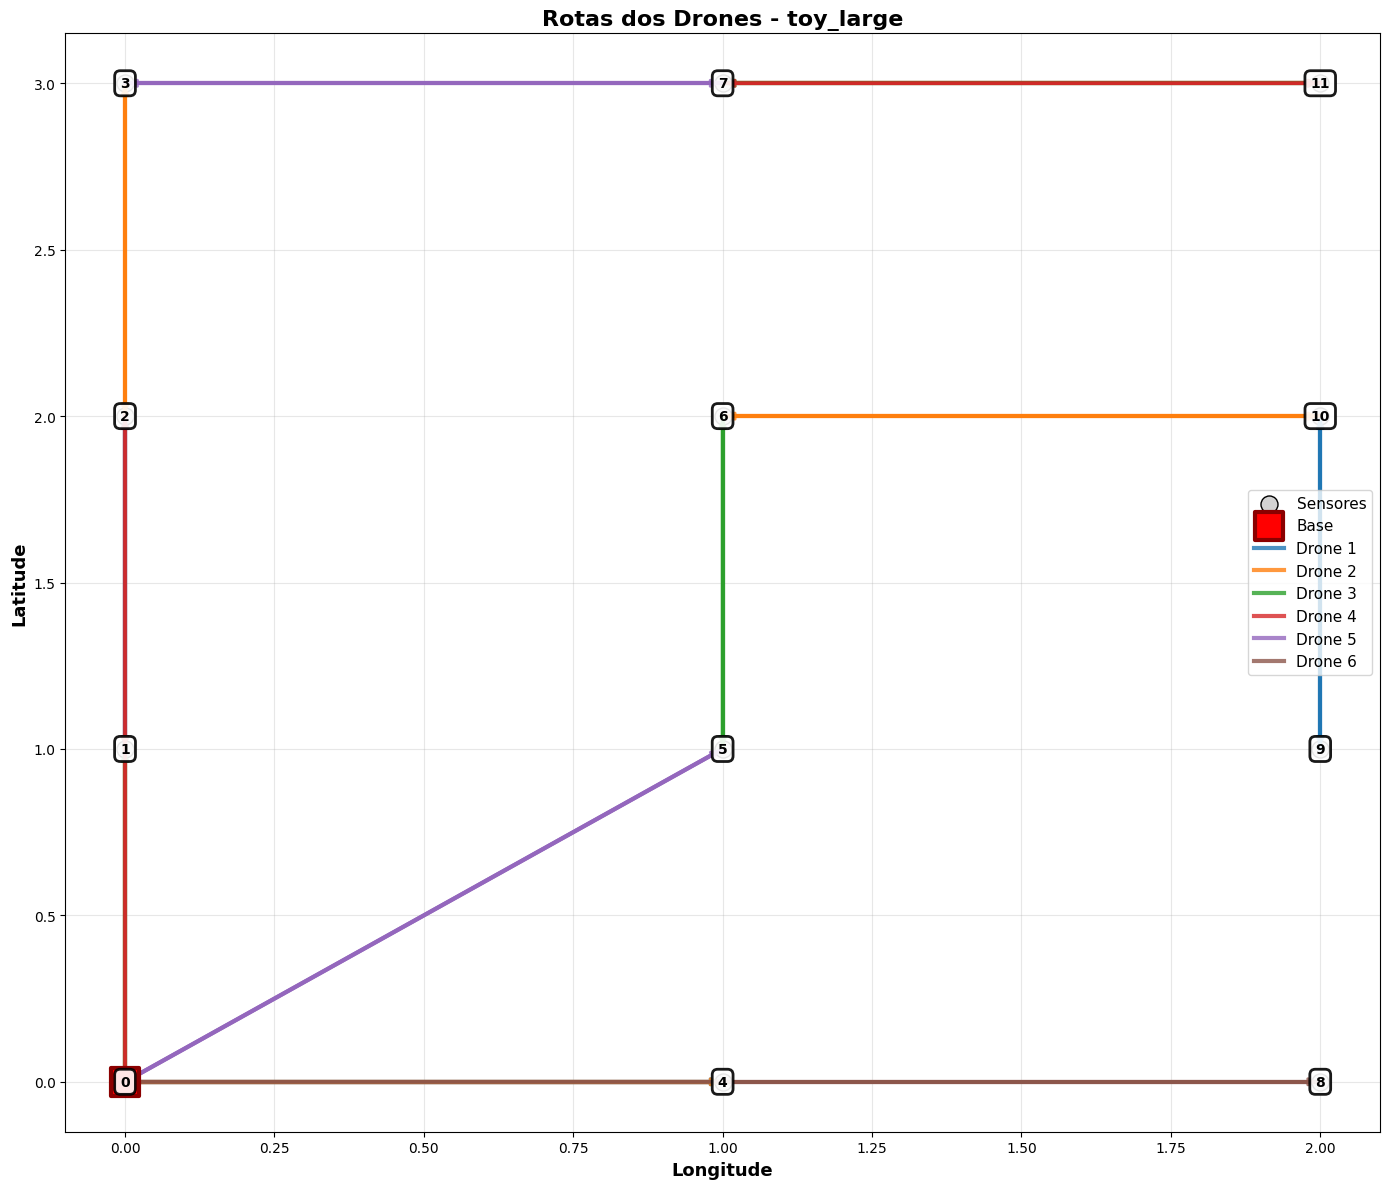

In [ ]:
import notebooks.instance_utils as instance_utils
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def extract_routes(cpx, x_id, K):
    """Extrai as rotas de cada drone da solução do CPLEX."""
    routes = []
    solution_values = cpx.solution.get_values()
    
    for k in range(K):
        route = []
        for (k_var, i, j), var_id in x_id.items():
            if k_var == k:
                value = solution_values[var_id]
                if value > 0.5:
                    route.append((i, j))
        routes.append(route)
    
    return routes

def plot_routes(routes, sensors, K, instance_name="Instance"):
    """Plota as rotas dos drones em um mapa."""
    fig, ax = plt.subplots(figsize=(14, 12))
    colors = list(mcolors.TABLEAU_COLORS.values())
    
    lats = [s[0] for s in sensors]
    lons = [s[1] for s in sensors]
    
    # Plotar sensores
    ax.scatter(lons[1:], lats[1:], c='lightgray', s=150, marker='o', 
               label='Sensores', zorder=2, edgecolors='black', linewidths=1)
    
    # Plotar base
    ax.scatter(lons[0], lats[0], c='red', s=400, marker='s', 
               label='Base', zorder=5, edgecolors='darkred', linewidths=3)
    
    # Plotar rotas
    for k, route in enumerate(routes):
        if not route:
            continue
        
        color = colors[k % len(colors)]
        
        for i, (from_node, to_node) in enumerate(route):
            lat1, lon1 = lats[from_node], lons[from_node]
            lat2, lon2 = lats[to_node], lons[to_node]
            
            label = f'Drone {k+1}' if i == 0 else None
            ax.plot([lon1, lon2], [lat1, lat2], 
                   color=color, linewidth=3, alpha=0.8, 
                   label=label, zorder=3)
            
            ax.annotate('', xy=(lon2, lat2), xytext=(lon1, lat1),
                       arrowprops=dict(arrowstyle='->', color=color, 
                                     lw=2.5, alpha=0.8), zorder=4)
    
    # Labels dos sensores
    for i, (lat, lon) in enumerate(zip(lats, lons)):
        ax.text(lon, lat, str(i), fontsize=10, ha='center', va='center',
               bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                        edgecolor='black', alpha=0.9, linewidth=2), zorder=6, fontweight='bold')
    
    ax.set_xlabel('Longitude', fontsize=13, fontweight='bold')
    ax.set_ylabel('Latitude', fontsize=13, fontweight='bold')
    ax.set_title(f'Rotas dos Drones - {instance_name}', fontsize=16, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def main():
    path = "../data/instances/toy_large.csv"
    data = instance_utils.read_instance(path, distance_type='euclidean')

    cpx_resp, x_id, y_id, T_id, elapsed = solve_CROMD_cplex(data['V'], data['A'], data['d'], data['C'], data['K'], data['Viz'], timelimit=300)
    
    T_value = cpx_resp.solution.get_objective_value()
    status = cpx_resp.solution.get_status()
    print("T_value:", T_value)
    print("Status:", status)
    
    # Plotar a solução
    instance_name = path.split('/')[-1].replace('.csv', '')
    routes = extract_routes(cpx_resp, x_id, data['K'])
    
    print("\n=== Rotas dos Drones ===")
    for k, route in enumerate(routes):
        if route:
            print(f"Drone {k+1}: {len(route)} arcos - {route}")
        else:
            print(f"Drone {k+1}: Não utilizado")
    
    plot_routes(routes, data['sensors'], data['K'], instance_name)

if __name__ == '__main__':
    main()
